In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import cv2
from glob import glob
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
csv_pth = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/annotations_train.csv"
df = pd.read_csv(csv_pth)
df.head()

,clip_id,video_id,procedure_id,start_timestamp,stop_timestamp,start_frame,stop_frame,action,next_action,verb,verb_class,noun,noun_class,notes
0,P01_01_0,P01_01,P01,00:01.00,00:01.97,60,119,palpate landmark,take swab,palpate,0,landmark,0,NaN
1,P01_01_1,P01_01,P01,00:02.00,00:05.97,120,359,take swab,prep site,take,1,swab,1,NaN
2,P01_01_2,P01_01,P01,00:06.00,00:07.97,360,479,prep site,drop swab,prep,2,site,2,NaN
3,P01_01_3,P01_01,P01,00:08.00,00:08.98,480,539,drop swab,take syringe,drop,3,swab,1,NaN
4,P01_01_4,P01_01,P01,00:09.00,00:17.97,540,1078,take syringe,inject lidocaine,take,1,syringe,3,NaN


/tmp/ipykernel_3526698/685089955.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="verb", palette="Set2", order=category_order)


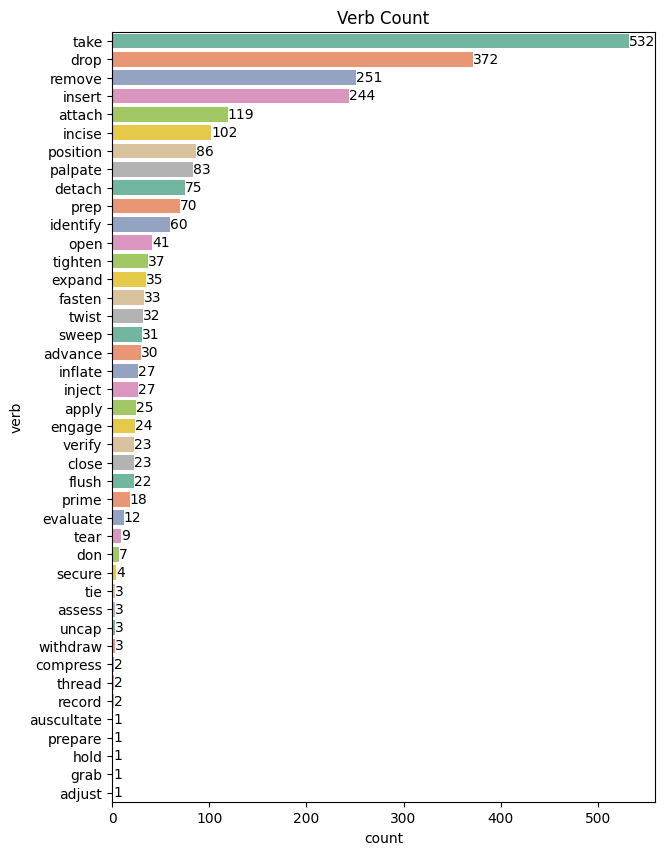

In [3]:
# count plot for verb and noun
category_order = df["verb"].value_counts().index
plt.figure(figsize=(7, 10)) 
ax = sns.countplot(data=df, y="verb", palette="Set2", order=category_order)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Verb Count")
plt.show()

/tmp/ipykernel_3526698/549508318.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="noun", palette="Set2", order=category_order)


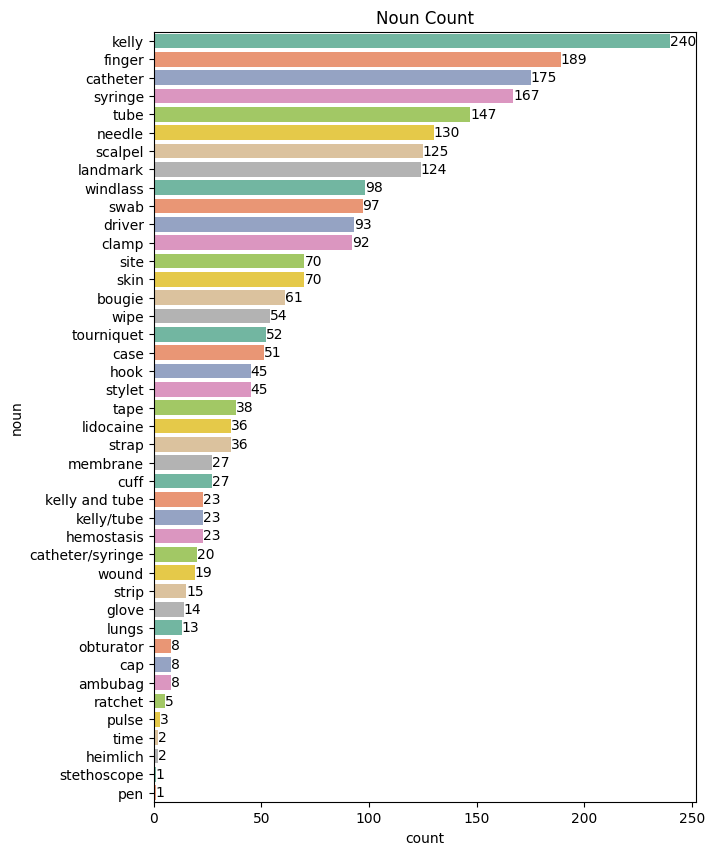

In [4]:
# count plot for noun
category_order = df["noun"].value_counts().index
plt.figure(figsize=(7, 10)) 
ax = sns.countplot(data=df, y="noun", palette="Set2", order=category_order)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Noun Count")
plt.show()

In [5]:
df["frame_interval"] = df["stop_frame"] - df["start_frame"]
print("Minimum frame interval: ", df["frame_interval"].min())
print("Maximum frame interval: ", df["frame_interval"].max())

Minimum frame interval:  29
Maximum frame interval:  1499


Idea is to create batches of video with 16 frames for each class. Each video will have a stride of 8 overlapping frames. 

In [6]:
frame_length = 16
overlap_frames = 8
# stimulate scenario
init_frame = 60
stop_frame = 119

def create_batches(init_frame, stop_frame, frame_length, overlap_frames):
    assert stop_frame > init_frame, "stop_frame must be greater than init_frame!"
    remaining_frames = (stop_frame - init_frame) % overlap_frames
    print("Remaining frames: ", remaining_frames)
    batch = (stop_frame - init_frame) // (frame_length - overlap_frames)
    print("Batch: ", batch)

    for i in range(batch):
        start_frame = init_frame
        end_frame = start_frame + frame_length
        # before reaching the final batch 
        if i==batch-2:
            init_frame = stop_frame - frame_length
        else:
            init_frame += (frame_length - overlap_frames)
        print(f"Batch {i}: start_frame = {start_frame}, end_frame = {end_frame}")

create_batches(init_frame, stop_frame, frame_length, overlap_frames)

Remaining frames:  3
Batch:  7
Batch 0: start_frame = 60, end_frame = 76
Batch 1: start_frame = 68, end_frame = 84
Batch 2: start_frame = 76, end_frame = 92
Batch 3: start_frame = 84, end_frame = 100
Batch 4: start_frame = 92, end_frame = 108
Batch 5: start_frame = 100, end_frame = 116
Batch 6: start_frame = 103, end_frame = 119


---

# Data Curation 

In [7]:
val = np.unique(df["action"])

action_cls2idx = {cls: idx for idx, cls in enumerate(val)}
print("Number of classes: ", len(val))
print("Available Classes: ", val)


Number of classes:  124
Available Classes:  ['adjust tourniquet' 'advance catheter' 'advance tube' 'apply clamp'
 'apply tape' 'assess pulse' 'attach ambubag' 'attach catheter'
 'attach heimlich' 'attach kelly and tube' 'attach needle' 'attach strip'
 'attach syringe' 'attach tape' 'attach tube' 'auscultate lungs'
 'close clamp' 'compress ambubag' 'detach ambubag' 'detach driver'
 'detach kelly' 'detach syringe' 'don glove' 'drop ambubag' 'drop bougie'
 'drop cap' 'drop case' 'drop catheter' 'drop catheter/syringe'
 'drop driver' 'drop hook' 'drop kelly' 'drop lidocaine' 'drop needle'
 'drop obturator' 'drop scalpel' 'drop stylet' 'drop swab' 'drop syringe'
 'drop tape' 'drop tube' 'drop wipe' 'engage driver' 'evaluate lungs'
 'expand kelly' 'fasten ratchet' 'fasten windlass' 'flush catheter'
 'grab windlass' 'hold driver' 'identify landmark' 'identify wound'
 'incise membrane' 'incise skin' 'incise strip' 'incise tape'
 'inflate cuff' 'inject lidocaine' 'insert bougie' 'insert cathete

In [8]:
# create CSV data with batch 
frame_length = 16
overlap_frames = 8

def create_batches(init_frame, stop_frame, frame_length, overlap_frames):
    assert stop_frame > init_frame, "stop_frame must be greater than init_frame!"
    batch = (stop_frame - init_frame) // (frame_length - overlap_frames)
    start_frame_list = []
    end_frame_list = []
    for i in range(batch):
        start_frame = init_frame
        end_frame = start_frame + frame_length
        # before reaching the final batch 
        if i==batch-2:
            init_frame = stop_frame - frame_length
        else:
            init_frame += (frame_length - overlap_frames)
        start_frame_list.append(start_frame)
        end_frame_list.append(end_frame)
    return start_frame_list, end_frame_list

data_list = []
for i in range(df.shape[0]):
    row_info = df.iloc[i]
    video_id = row_info["video_id"]
    start_frame = row_info["start_frame"]
    stop_frame = row_info["stop_frame"]
    action = row_info["action"]
    start_frame_list, end_frame_list = create_batches(start_frame, stop_frame, frame_length, overlap_frames)
    for batch_start_frame, batch_end_frame in zip(start_frame_list, end_frame_list):
        clip_id = f"{video_id}_{batch_start_frame:06d}_{batch_end_frame:06d}"
        output_dict = {"video_id": video_id, "clip_id":clip_id, "start_frame": batch_start_frame, "end_frame": batch_end_frame, "action": action}
        data_list.append(output_dict)

df_data = pd.DataFrame(data_list)
df_data["action_idx"] = df_data["action"].map(action_cls2idx)
df_data.to_csv("./outputs/data_prep.csv", index=False)
df_data.head()


,video_id,clip_id,start_frame,end_frame,action,action_idx
0,P01_01,P01_01_000060_000076,60,76,palpate landmark,67
1,P01_01,P01_01_000068_000084,68,84,palpate landmark,67
2,P01_01,P01_01_000076_000092,76,92,palpate landmark,67
3,P01_01,P01_01_000084_000100,84,100,palpate landmark,67
4,P01_01,P01_01_000092_000108,92,108,palpate landmark,67


/tmp/ipykernel_3526698/3697841237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_data, y="action", palette="Set2", order=category_order)


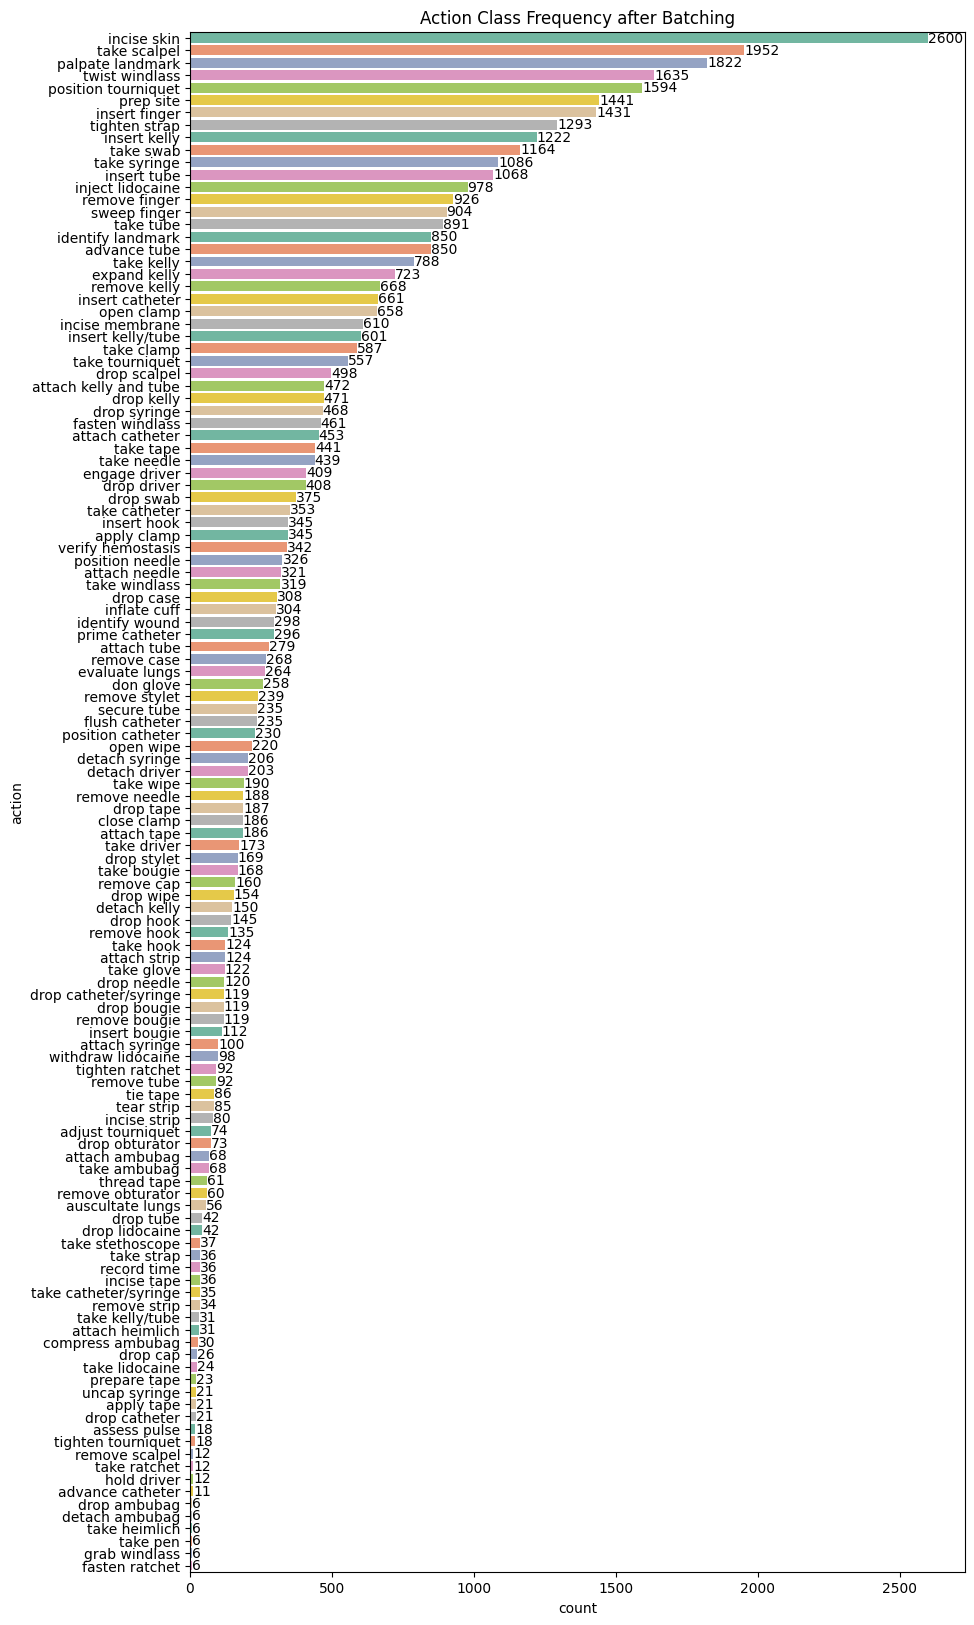

In [23]:
category_order = df_data["action"].value_counts().index
plt.figure(figsize=(10, 20)) 
ax = sns.countplot(data=df_data, y="action", palette="Set2", order=category_order)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Action Class Frequency after Batching")
plt.show()

In [10]:
# go through each video to figure the video size 

video_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/train"
video_data_list = []
for video_path in glob(os.path.join(video_dir, "*.mp4")):
    video_name = os.path.basename(video_path)
    cap = cv2.VideoCapture(video_path)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    cap.release()
    output_dict = {"video_name": video_name, "width": width, "height": height}
    video_data_list.append(output_dict)

video_data_df = pd.DataFrame(video_data_list)
video_data_df

,video_name,width,height
0,P05_34.mp4,1280.0,920.0
1,P01_43.mp4,1920.0,1080.0
2,P03_05.mp4,1920.0,1080.0
3,P01_29.mp4,1920.0,1080.0
4,P02_02.mp4,1920.0,1080.0
...,...,...,...
136,P01_10.mp4,1920.0,1080.0
137,P02_25.mp4,1920.0,1080.0
138,P02_21.mp4,1920.0,1080.0
139,P02_45.mp4,1920.0,1080.0


In [11]:
print("Minimum width: ", video_data_df["width"].min())
print("Minimum height: ", video_data_df["height"].min())
print("Maximum width: ", video_data_df["width"].max())
print("Maximum height: ", video_data_df["height"].max())


Minimum width:  1280.0
Minimum height:  920.0
Maximum width:  1920.0
Maximum height:  1080.0


Given that the minimum width and height of the video is (1280, 920) and for efficient training purpose <br>
all videos will be resize to (960, 540)

In [15]:
# split data into train and val 
x = df_data["clip_id"].to_list()
y = df_data["action_idx"].to_list()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
train_df = pd.DataFrame({"clip_id": x_train})
train_df["split"] = "train"
val_df = pd.DataFrame({"clip_id": x_val})
val_df["split"] = "val"
train_val_df = pd.concat([train_df, val_df], ignore_index=True)
merge_df = df_data.merge(train_val_df, on="clip_id")
# merge_df.to_csv("./outputs/data_prep_split.csv", index=False)
merge_df.head()


,video_id,clip_id,start_frame,end_frame,action,action_idx,split
0,P01_01,P01_01_000060_000076,60,76,palpate landmark,67,train
1,P01_01,P01_01_000068_000084,68,84,palpate landmark,67,train
2,P01_01,P01_01_000076_000092,76,92,palpate landmark,67,val
3,P01_01,P01_01_000084_000100,84,100,palpate landmark,67,val
4,P01_01,P01_01_000092_000108,92,108,palpate landmark,67,val


/tmp/ipykernel_3526698/2074047267.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merge_df.query("split == 'train'"), y="action", palette="Set2", order=category_order)


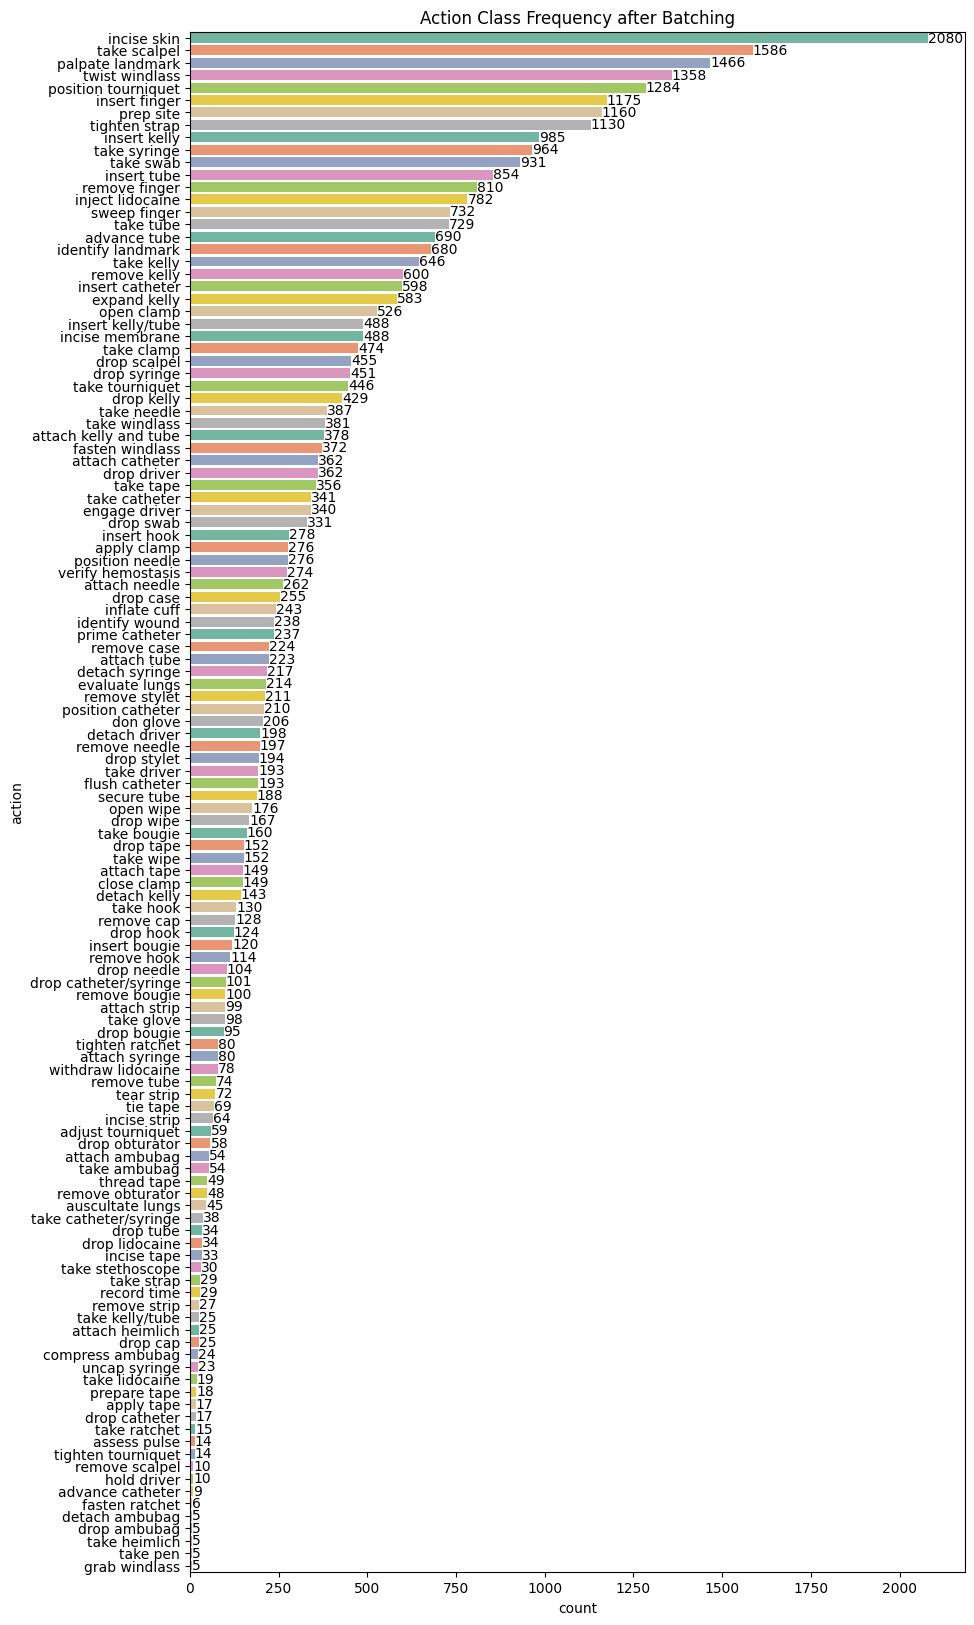

In [ ]:
category_order = merge_df.query("split == 'train'")["action"].value_counts().index
plt.figure(figsize=(10, 20)) 
ax = sns.countplot(data=merge_df.query("split == 'train'"), y="action", palette="Set2", order=category_order)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Train Set")
plt.show()

/tmp/ipykernel_3526698/4020671160.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merge_df.query("split == 'val'"), y="action", palette="Set2", order=category_order)


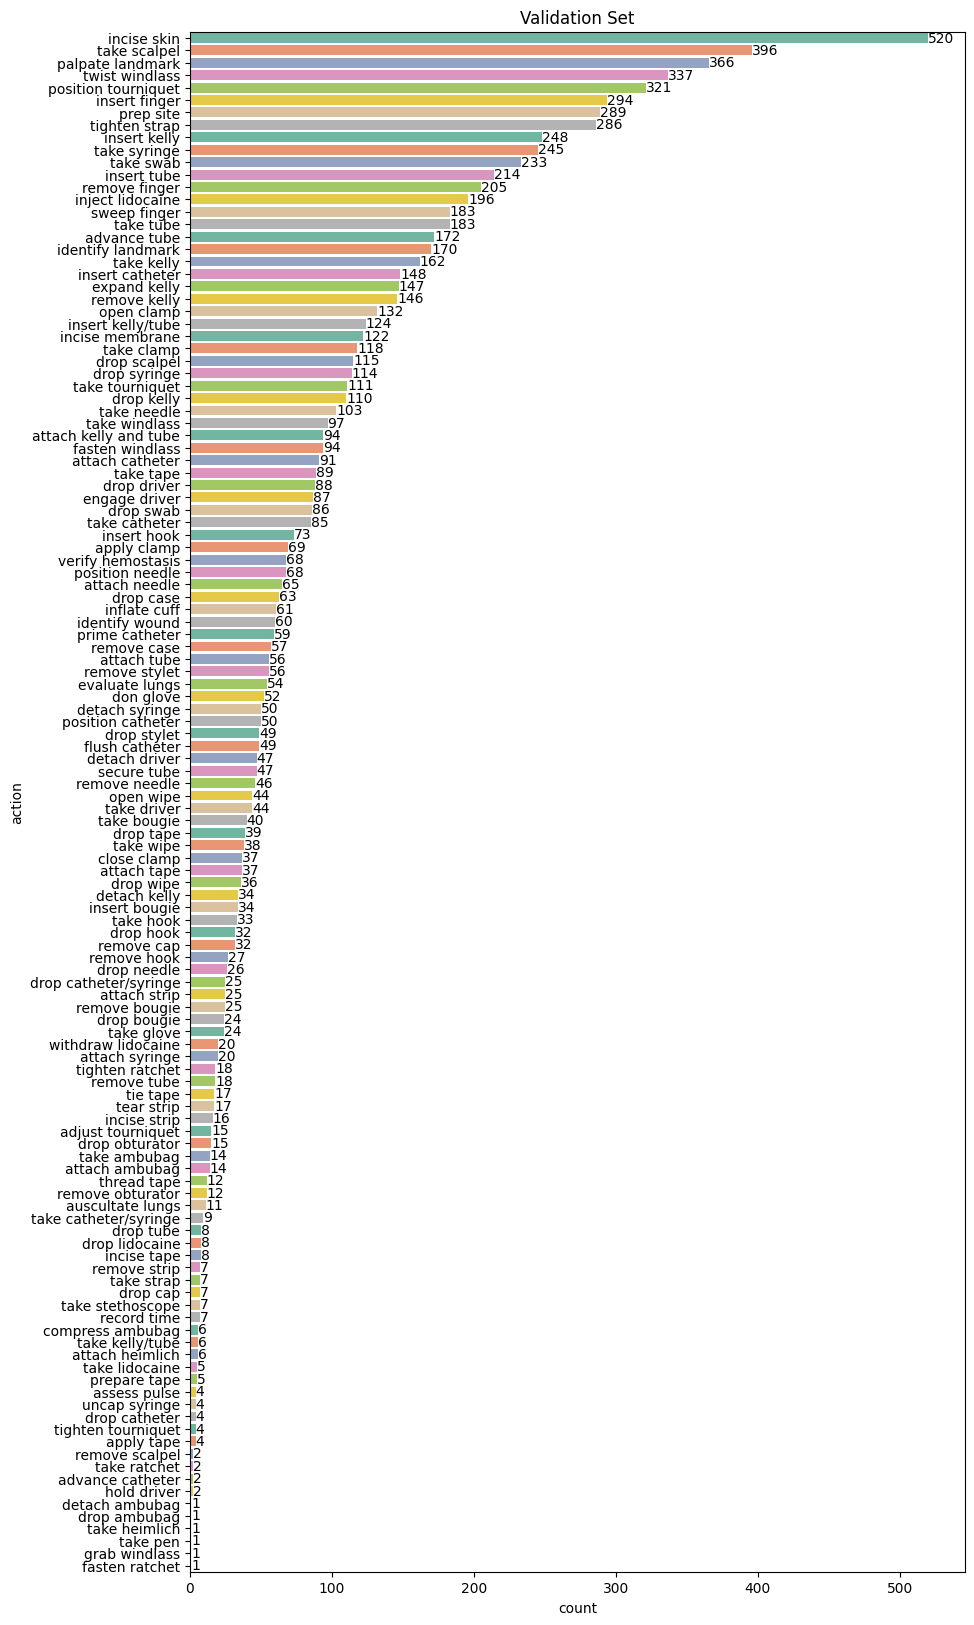

In [26]:
category_order = merge_df.query("split == 'val'")["action"].value_counts().index
plt.figure(figsize=(10, 20)) 
ax = sns.countplot(data=merge_df.query("split == 'val'"), y="action", palette="Set2", order=category_order)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Validation Set")
plt.show()

---

# Create Dataset

In [2]:
video_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/train"
output_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset"
video_resize = (256, 256) # VJEPA2 model input size
df_split = pd.read_csv("./outputs/data_prep_split.csv")
for i in range(len(df_split)):
    row_info = df_split.iloc[i]
    video_id = row_info["video_id"]
    clip_id = row_info["clip_id"]
    start_frame = row_info["start_frame"]
    end_frame = row_info["end_frame"]
    split = row_info["split"]
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    # dedicate split path train/val
    split_output_dir = os.path.join(output_dir, split)
    if not os.path.exists(split_output_dir):
        os.makedirs(split_output_dir)
    clip_output_path = os.path.join(split_output_dir, f"{clip_id}.mp4")
    try:
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        # Define video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = cap.get(cv2.CAP_PROP_FPS)
        out = cv2.VideoWriter(clip_output_path, fourcc, fps, video_resize)
        frame_idx = start_frame
        # === Read and process frames ===
        frame_idx = start_frame
        while cap.isOpened() and frame_idx < end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            # Resize
            frame_resized = cv2.resize(frame, video_resize, interpolation=cv2.INTER_AREA)
            # Write frame
            out.write(frame_resized)
            frame_idx += 1

        cap.release()
        out.release()
    except Exception as e:
        print(e)
        print(f"Error processing video {video_id}")
        continue
    